# Precipitation Linear Fit and Histogram

## 10/11/25

As the title suggests, in this notebook I create linear fits and histograms for the precipitation value in the ERA5-Land dataset.

Contents:
1. Linear Fits
2. Histograms

## 1.0. Linear Fits

DJF slope=0.76±0.31 mm/yr
MAM slope=0.18±0.22 mm/yr
JJA slope=0.38±0.28 mm/yr
SON slope=0.13±0.28 mm/yr


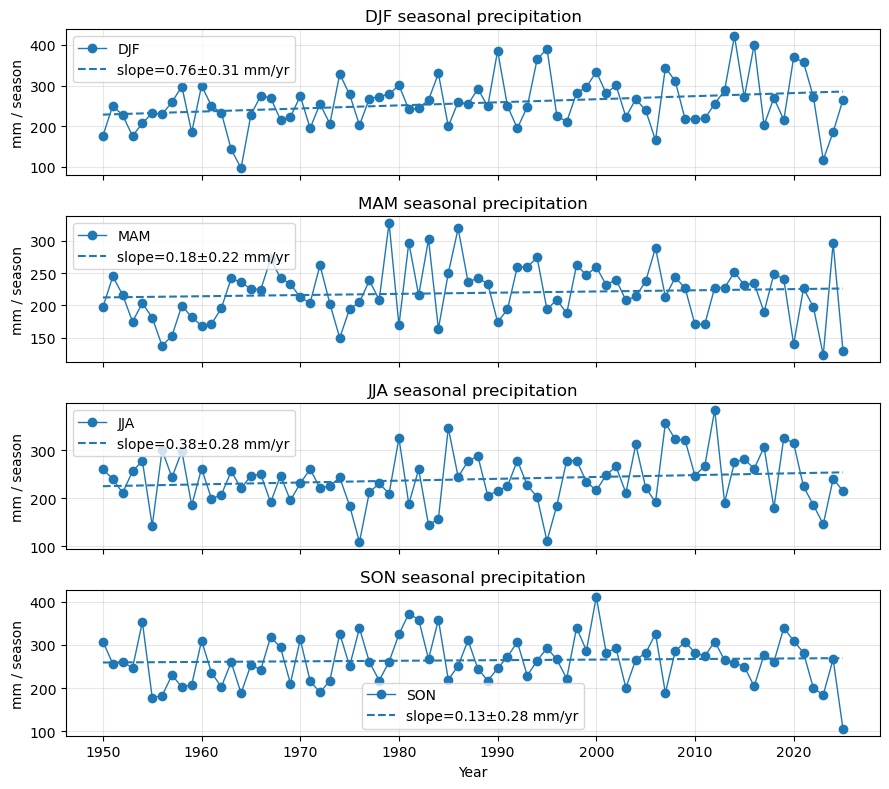

In [3]:
# Importing relevant modules
from scipy.optimize import curve_fit
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Loading dataset
data_path = Path(r"C:\Users\itsna\OneDrive\Desktop\MSc Work\DataSets\temp_precipitation_uk.nc")
ds = xr.open_dataset(data_path)

# Time array
t = pd.to_datetime(ds["valid_time"].values)
days_in_month = t.days_in_month.to_numpy()

# Converting to mm/month
tp = ds["tp"].values
tp_mm_day = tp * 1000.0
tp_mm_month = tp_mm_day * days_in_month[:, None, None]

# avg precip each month
tp_uk_month = np.nanmean(tp_mm_month, axis=(1, 2))

# Putting in DataFrame
df = pd.DataFrame({
    "date": t,
    "precip_mm_month": tp_uk_month
})
df["month"] = df["date"].dt.month
df["year"]  = df["date"].dt.year

# Assigning seasons (Dec goes to next year DJF)
def season_label(m):
    if m in (12, 1, 2): return "DJF"
    if m in (3, 4, 5):  return "MAM"
    if m in (6, 7, 8):  return "JJA"
    return "SON"
df["season"] = df["month"].apply(season_label)

# Season-year
df["season_year"] = df["year"]
df.loc[df["month"] == 12, "season_year"] = df.loc[df["month"] == 12, "year"] + 1

# Summing monthly totals to seasonal totals
seasonal = (
    df.groupby(["season_year", "season"])["precip_mm_month"]
      .sum()
      .reset_index()
      .rename(columns={"precip_mm_month": "precip_mm_season"})
)

# Wide columns DJF/MAM/JJA/SON
seasonal_wide = (
    seasonal.pivot(index="season_year", columns="season", values="precip_mm_season")
            .sort_index()
)
seasonal_wide = seasonal_wide.dropna(how="all")

# Least squares linear fit
def linear_model(x, m, b):
    return m * x + b

fig, axes = plt.subplots(4, 1, figsize=(9, 8), sharex=True)
seasons = ["DJF", "MAM", "JJA", "SON"]

fit_params = {}

for ax, s in zip(axes, seasons):
    y = seasonal_wide[s].to_numpy(dtype=float)
    x = seasonal_wide.index.to_numpy(dtype=float)
    
    # Removing nan values
    mask = np.isfinite(x) & np.isfinite(y)
    x_fit = x[mask]
    y_fit = y[mask]

    # Least squares fit (no sigma)
    popt, pcov = curve_fit(linear_model, x_fit, y_fit)
    m, b = popt
    m_err = np.sqrt(pcov[0, 0])  # 1σ uncertainty on slope
    fit_params[s] = (m, b, m_err)

    # Plotting  data
    ax.plot(x_fit, y_fit, marker="o", linewidth=1.0, label=s)

    # Plotting fit
    x_line = np.linspace(x_fit.min(), x_fit.max(), 200)
    y_line = linear_model(x_line, m, b)
    ax.plot(
        x_line,
        y_line,
        linestyle="--",
        color="tab:blue",
        linewidth=1.5,
        label=f"slope={m:.2f}±{m_err:.2f} mm/yr"
    )

    ax.set_ylabel("mm / season")
    ax.set_title(f"{s} seasonal precipitation")
    ax.grid(alpha=0.3)
    ax.legend()
    
    print(f"{s} slope={m:.2f}±{m_err:.2f} mm/yr")

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

While the uncertainties are large, the DJF slope is definitely the largest.

## 2.0. Histograms

The season with the steepest slope should have the largest seperation between pre and post 1990 when plotted as a histogram.

For this reason I used the winter season for my histogram plot:

Number of DJF monthly entries < 1990: 119
Number of DJF monthly entries ≥ 1990: 108


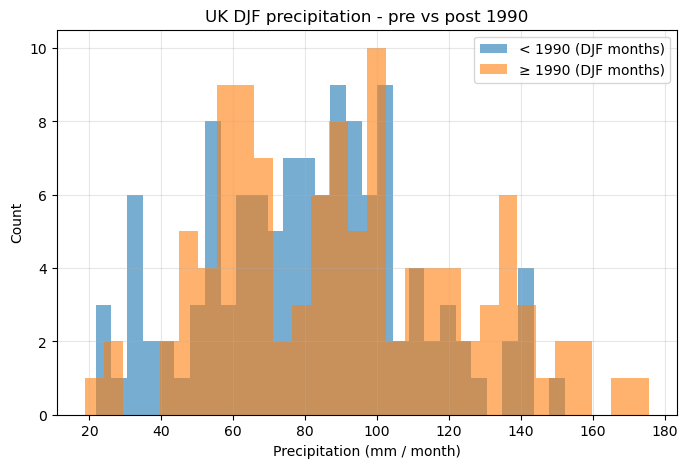

In [16]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Time and month lengths
time = pd.to_datetime(ds["valid_time"].values)
days_in_month = time.days_in_month.to_numpy()

# Converting to mm/month
tp_m_day = ds["tp"].values
tp_mm_day = tp_m_day * 1000.0
tp_mm_month = tp_mm_day * days_in_month[:, None, None]

# monthly avg precipitation
tp_monthly_uk = np.nanmean(tp_mm_month, axis=(1, 2))

# Year and month arrays
month = time.month.values
year  = time.year.values

# Assigning seasons
season = np.empty_like(month, dtype=object)
season[(month == 12) | (month <= 2)] = "DJF"
season[(month >= 3) & (month <= 5)] = "MAM"
season[(month >= 6) & (month <= 8)] = "JJA"
season[(month >= 9) & (month <= 11)] = "SON"

# Season-year (Dec goes to next year DJF)
season_year = year.copy()
season_year[month == 12] = season_year[month == 12] + 1

# Keeping only DJF months
djf_mask = (season == "DJF")
djf_precip = tp_monthly_uk[djf_mask]
djf_year   = season_year[djf_mask]

# Splitting DJF months into pre and post 1990
mask_pre  = djf_year < 1990
mask_post = djf_year >= 1990

precip_pre  = djf_precip[mask_pre]
precip_post = djf_precip[mask_post]

print(f"Number of DJF monthly entries < 1990: {precip_pre.size}")
print(f"Number of DJF monthly entries ≥ 1990: {precip_post.size}")

plt.figure(figsize=(8, 5))
bins = 30

plt.hist(precip_pre,  bins=bins, alpha=0.6, label="< 1990 (DJF months)")
plt.hist(precip_post, bins=bins, alpha=0.6, label="≥ 1990 (DJF months)")

plt.xlabel("Precipitation (mm / month)")
plt.ylabel("Count")
plt.title("UK DJF precipitation - pre vs post 1990")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()